In [969]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import os
import numpy as np
from scipy.special import expit as sigmoid
from numpy.linalg import inv
dir_path = os.getcwd()


# Exercise 1: Learning in discrete graphical models

Soit les observations $Y = (Y_1, ..., Y_n)$ avec 

$$
Y_i = 
 \bigg(
    \begin{array}{ll}
        X_i \\
        Z_i
    \end{array}
 \bigg)
$$

alors 
$$ p(y) = \prod_i p(y_i) = \prod_i p(x_i | z_i) p(z_i) = \prod_i \theta_{z_i x_i} \pi_{z_i} $$
$$ p(y) = \prod_{m \in \mathcal{M}} \pi_m^{n_m} \prod_{m \in \mathcal{M}, k \in \mathcal{K}} \theta_{mk}^{n_{mk}} $$ où 
$n_{mk} = \sum_i \mathbb{1}\{x_i = k, z_i = m\} =$ "Nombre de couples $(k, m)$ dans les observations"

et 

$n_m = \sum_i \sum_k n_{m, k} = \sum_i \mathbb{1}\{z_i = m\} =$ "Nombre d'observations où  $z_i = m$"

Alors, on veut maximiser
$$ log(p(y)) = \sum_m n_m log(\pi_m) + \sum_{m, k} n_{mk} log(\theta_{mk})$$
sous les contraintes 
$\sum_m \pi_m = 1$
et
$\sum_{m, k} \theta_{mk} = 1$

Posons donc le Lagrangien :

$$ \mathcal{L}(\pi, \theta, \lambda, \mu) =  \sum_m n_m log(\pi_m) + \sum_{m, k} n_{mk} log(\theta_{mk}) - \lambda(\sum_m \pi_m - 1) - \mu(\sum_{m, k} \theta_{mk} - 1)$$ 

En dérivant par rapport à $\pi$:
$$ \frac{\partial \mathcal{L}}{\partial \pi_m} = \frac{n_m}{\pi_m} - \lambda = 0  \Rightarrow \pi_m = \frac{n_m}{\lambda}$$ or avec la contrainte $$\sum_m \pi_m = 1 \Rightarrow \hat{\pi}_m = \frac{n_m}{n}$$

De même, en dérivant par rapport à $\theta$:
$$ \frac{\partial \mathcal{L}}{\partial \theta_{mk}} = \frac{n_{mk}}{\theta_{mk}} - \mu = 0  \Rightarrow \theta_{mk} = \frac{n_{mk}}{\mu}$$ or avec la contrainte $$\sum_{m, k} \theta_{mk} = 1 \Rightarrow \hat{\theta}_{mk} = \frac{n_{mk}}{n}$$

# Exercice 2 :  Linear classification

In [920]:
modelNames = ['A', 'B', 'C']
d_types = ['train', 'test']
data = dict()
for model in modelNames:
    for d_type in d_types:
        path = dir_path +"/"+"classification_data_HWK1/classification" +model +'.' + d_type 
        data[model+'_'+d_type] = pd.read_csv(path, sep='\t', header=None).values

### 1) Generative model: LDA

(a) Pour une seule observation :
$$ p(y|x) \propto p(x|y)p(y) = \pi^y (1-\pi)^{1-y} p(x|y)$$
$$ p(y|x) \propto \pi^y (1-\pi)^{1-y} (det(\Sigma))^{-n/2} exp(-\frac{y}{2}(x-\mu_1)^T \Sigma^{-1} (x-\mu_1) - \frac{1-y}{2}(x - \mu_0)^T \Sigma^{-1}(x-\mu_0)) $$

$$ p(y|x) \propto \pi^y (1-\pi)^{1-y} (det(\Sigma))^{-n/2} \ exp\big(y x^T \Sigma^{-1} (\mu_1 - \mu_0) + \frac{y}{2}(\mu_0^T \Sigma^{-1}\mu_0 - \mu_1^T \Sigma^{-1}\mu_1) -\frac{1}{2}(x - \mu_0)^T \Sigma^{-1}(x-\mu_0)\big) $$

Donc, pour n observations $(X_i, Y_i)$ iid, on a :

$$ log\big(p(y|x)\big) = log(\pi)\sum_i y_i + log(1-\pi)\sum_i(1- y_i) -\frac{n}{2}log\big(det(\Sigma)\big) + \sum_i y_i x_i^T\Sigma^{-1}(\mu_1 - \mu_0) + (\mu_0^T \Sigma^{-1}\mu_0 - \mu_1^T \Sigma^{-1}\mu_1)\sum_i \frac{y_i}{2} \\ -\frac{1}{2}\sum_i (x_i - \mu_0)^T \Sigma^{-1}(x_i-\mu_0) + Cste  $$

Comme cette expression est concave en $\pi, \mu_0, \mu_1$, et  $\Sigma$, on cherche un maximum pour chacun des paramètre lorsque le gradient par rapport à ce paramètre vaut 0.

* Estimation de $\mu_0$:
$$
\nabla_{\mu_0}\Big(log\big(p(y|x)\big)\Big) = - \sum_i y_i x_i^T \Sigma^{-1} + 2 \mu_0^T \Sigma^{-1} \sum_i \frac{y_i}{2} + \sum_i (x_i-\mu_0)^T \Sigma^{-1} = 0 
$$

$$ \Leftrightarrow  \mu_0^T  \sum_i y_i + \sum_i x_i^T - \mu_0^T \sum_i 1  = \sum_i y_i x_i^T $$

$$ \Leftrightarrow  \mu_0^T  \sum_i (1-y_i) = \sum_i x_i^T(1-y_i)  $$
$$ \Leftrightarrow  \hat{\mu}_0 = \frac{\sum_i x_i^T(1-y_i)}{\sum_i (1-y_i)}  $$
donc l'estimateur du maximum de vraisemblance pour $\mu_0$ est la moyenne empirique des $x_i$ pour les observations où $y_i = 0$


* Estimation de $\mu_1$:
$$\nabla_{\mu_1}\Big(log\big(p(y|x)\big)\Big) = \sum_i y_i x_i^T \Sigma^{-1} - 2 \mu_1^T \Sigma^{-1} \sum_i \frac{y_i}{2}  = 0 $$
$$ \Leftrightarrow \sum_i y_i x_i = \mu_1 \sum_i y_i $$
$$ \Leftrightarrow  \hat{\mu}_1  = \frac{\sum_i y_i x_i}{\sum_i y_i} $$
donc l'estimateur du maximum de vraisemblance pour  $\mu_1$  est la moyenne empirique des $x_i$ pour les observations où $y_i=1$

* Estimation de $\pi$:
$$\nabla_\pi \Big(log\big(p(y|x)\big)\Big) = \frac{\sum_i y_i}{\pi} - \frac{\sum_i (1-y_i)}{1-\pi} = 0$$
$$\Leftrightarrow \hat{\pi} = \frac{\sum_i y_i}{n}  $$
donc l'estimateur du maximum de vraisemblance de $\pi$ est la moyenne empirique des $y_i$


* Estimation de $\Sigma$:

En posant $\Lambda = \Sigma^{-1}$ on peut réecrire, en ne gardant que les termes dépendant de $\Lambda$:
$$
log\big(p(y|x)\big) = \frac{n}{2}log\big(det(\Lambda)\big) + \sum_i tr\big(y_i x_i^T\Lambda(\mu_1 - \mu_0)\big) + \big(tr(\mu_0^T \Lambda \mu_0) - tr(\mu_1^T \Lambda\mu_1)\big)\sum_i \frac{y_i}{2} -\frac{1}{2}\sum_i tr \big( (x_i - \mu_0)^T \Lambda(x_i-\mu_0)\big) + Cste
$$
$$
= \frac{n}{2}log\big(det(\Lambda)\big) + tr\big(\Lambda \sum_i y_i x_i(\mu_1 - \mu_0)^T\big) + \big(tr(\Lambda \ \mu_0 \mu_0^T) - tr(\Lambda \mu_1 \mu_1^T)\big)\sum_i \frac{y_i}{2} 
-\frac{1}{2} tr \big(  \Lambda \sum_i (x_i - \mu_0)(x_i-\mu_0)^T\big) + Cste
$$
or, pour A, B deux matrices carrées $\nabla_A tr(AB) = B^T$, et $\nabla_A\Big(log\big(det(A)\big)\Big) = A^{-1}$
d'où
$$
\nabla_\Lambda \Big(log\big(p(y|x)\big)\Big) = \frac{n}{2} \Sigma
+ \sum_i y_i x_i^T(\mu_1 - \mu_0)
+ (\mu_0^T \mu_0 - \mu_1^T \mu_1)\sum_i \frac{y_i}{2}
-\frac{1}{2} \sum_i (x_i - \mu_0)^T(x_i-\mu_0) = 0
$$
$$
\Leftrightarrow \Sigma = \frac{1}{n} \big(
\sum_i y_i \big( -2 x_i^T\mu_1 + \mu_1^T \mu_1 + x_i^T x_i - x_i^T x_i\big)
+ \sum_i y_i \big( 2 x_i^T\mu_0 - \mu_0^T \mu_0 + x_i^T x_i - x_i^T x_i \big)
+ \sum_i (x_i - \mu_0)^T(x_i-\mu_0) \big)
$$
$$
\Leftrightarrow \Sigma = \frac{1}{n} \big(
\sum_i y_i (x_i - \mu_1)^T(x_i - \mu_1)
- \sum_i y_i (x_i - \mu_0)^T(x_i - \mu_0)
+ \sum_i (x_i - \mu_0)^T(x_i-\mu_0) \big)
$$
$$
\Leftrightarrow \hat\Sigma = \frac{1}{n} \big(
\sum_i y_i (x_i - \mu_1)^T(x_i - \mu_1)
+ \sum_i (1-y_i) (x_i - \mu_0)^T(x_i-\mu_0) \big)
$$

* Calul de $p(y = 1|x)$:
$$
p(y = 1|x) = \frac{p(x|y=1)p(y=1)}{p(x|y=1)p(y=1) + p(x|y=0)p(y=0)} = \frac{1}{1+\frac{p(x|y=0)p(y=0)}{p(x|y=1)p(y=1)}}
$$
$$
p(y = 1|x) = \frac{1}{1+\frac{1-\pi}{\pi}exp\big(-\frac{1}{2}(x-\mu_0)^T\Sigma^{-1}(x-\mu_0) + \frac{1}{2}(x-\mu_1)^T\Sigma^{-1}(x-\mu_1) \big)}
$$
$$
p(y = 1|x) = \frac{1}{1+exp\big( x^T\Sigma^{-1}(\mu_0-\mu_1) + \frac{1}{2}(\mu_1^T\Sigma^{-1}\mu_1 - \mu_0^T\Sigma^{-1}\mu_0) + log(\frac{1-\pi}{\pi})\big)} = \sigma\big( a^T x + b \big)
$$
avec $a = (\mu_1-\mu_0)^T\Sigma^{-1} $ et $b = \frac{1}{2}( \mu_1^T\Sigma^{-1}\mu_1 - \mu_0^T\Sigma^{-1}\mu_0) + log(\frac{1-\pi}{\pi})$

Ainsi 
$$
p(y = 1|x) = 0.5
$$
$$
\Leftrightarrow a^Tx + b  = 0
$$

In [989]:
def getLDAParametersForModel(modelName):
    dataForModel = data[modelName+ '_train']
    
    # x0 est l'ensemble des xi pour lesquels yi = 0
    x0 = dataForModel[:, 0:2][dataForModel[:, 2]==0]
    mu0 = np.mean(x0, axis=0)
    
    # x1 est l'ensemble des xi pour lesquels yi = 1
    x1 = dataForModel[:, 0:2][dataForModel[:, 2]==1]
    mu1 = np.mean(x1, axis=0)
    
    pi = np.mean(dataForModel[:, 2])

    sigma = (np.dot((x0 - mu0).T, x0 - mu0) + np.dot((x1 - mu1).T, x1 - mu1))/dataForModel.shape[0]
    
    return pi, mu0, mu1, sigma

def computeABparam(pi, mu0, mu1, sigma):
    sigmainv = inv(sigma)
    a = np.dot((mu1 - mu0).T, sigmainv)
    b = 1/2 * ( np.dot(mu1.T, np.dot(sigmainv, mu1)) - np.dot(mu0.T, np.dot(sigmainv, mu0)) ) + np.log((1-pi)/pi)
    return a, b

def plotLDAForModel(modelName): 
    pi, mu0, mu1, sigma = getLDAParametersForModel(modelName)
    print()
    a, b = computeABparam(pi, mu0, mu1, sigma)
    
    fig, ax = plt.subplots()
    dataForModel = data[modelName+ '_train']

    x0min = np.min(dataForModel[:, 0])
    x0max = np.max(dataForModel[:, 0])
    
    xx0 = np.arange(x0min, x0max, (x0max-x0min)/100)
    xx1 = -a[0]/a[1]*xx0 - b/a[1]
    ax.plot(xx0, xx1)
    
    x_abs = dataForModel[:, 0]
    x_ord = dataForModel[:, 1]
    y = dataForModel[:, 2]
    ax.scatter(x_abs, x_ord, c = y)
    
    
    title = "LDA Data plot for Model "+modelName
    plt.title(title)
    plt.xlabel('x0')
    plt.ylabel('x1')


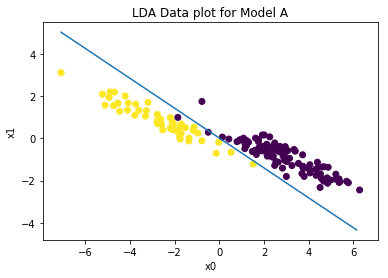

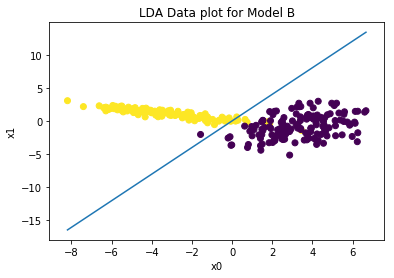

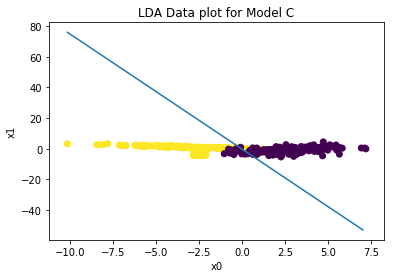

In [990]:
for name in modelNames:
    plotLDAForModel(name)

In [986]:
def printLDAParametersForModel(modelName):
    pi, mu0, mu1, sigma = getLDAParametersForModel(modelName)
    print(pi, mu0, mu1, sigma)
#     print('For Logistic regression of model {0} learnt parameters are :\n\tpi = {1:.3f}\n\tmu0 = [{2:.3f},{2:.3f}]\n\tmu1 = [{2:.3f},{2:.3f}]\n\tsigma = {4:.3f}\n'.format(modelName,pi, mu0[0], mu1, sigma))
        
for name in modelNames:
    printLDAParametersForModel(name)

0.3333333333333333 [ 2.89970947 -0.893874  ] [-2.69232004  0.866042  ] [[ 2.44190897 -1.13194024]
 [-1.13194024  0.61375465]]
0.5 [ 3.34068896 -0.83546333] [-3.21670734  1.08306733] [[ 3.34623467 -0.13516489]
 [-0.13516489  1.73807475]]
0.625 [ 2.79304824 -0.83838667] [-2.94232885 -0.9578284 ] [[ 2.88039225 -0.63405081]
 [-0.63405081  5.19952435]]


### 2) Logistic Regression

f is of the form $ f(x) = w^TX + b . \ $ <br>
We can augment X with a row of 1 to remove b of the Equation. <br>
f thus become $ f(x) = w^T\tilde{X} $ <br>
with $\tilde{X} = (X, 1)$

We will need to solve the Modified normal equations using the Newton's method described in the class material


Then if we want to plot $ p(y = 1|x) = 0.5 $ we need to solve the equation $$  \frac{\mathrm{1} }{\mathrm{1} + e^-f(x) } = 0.5  $$ which is equivalent to solving $ f(x) = 0 $ 

We thus need to represent the line of equation $ x_2 = \frac{- b - w_1*x_1}{w_2} $


In [959]:
w0init = dict()
w0init['A'] = np.array([[0.7705846734165602], [0.5281598619924476], [0.41861207653102495]])
w0init['B'] = np.array([[0.2237963501074024], [0.03727566587354736], [0.5629049044816309]])
w0init['C'] = np.array([[0.12116464647012481], [0.2976639368542129], [0.5205404651440133]])



In [960]:
def getLogRegParametersForModel(modelName):
    Y = np.copy(data[modelName +'_train'][:, 2:3])
    X = np.copy(data[modelName + '_train'][:, 0:3])
    
    # we replace the third row by the augmented row
    X[:, 2] = 1
    X_t = np.transpose(X)
    
    w = w0init[modelName]
    eta = np.transpose(sigmoid(np.dot(np.transpose(w), X_t)))
    etaa = eta*(1-eta)
    D = np.diag(etaa[:, 0])
    Y_tilde = Y - eta
    
    for t in range(10000):   
        inv = np.linalg.inv(np.dot(np.dot(X_t, D), X))
        first = np.dot(inv, X_t)
        second = np.dot(first, Y_tilde)
        w = w + second

        eta = np.transpose(sigmoid(np.dot(np.transpose(w), X_t)))
        etaa = eta*(1-eta)
        D0 = np.diag(etaa[:,0])
        Y_tilde = Y - eta
        
    return w


In [961]:
def LogReg_proba_lim(x1,w1,w2,b):
    return -1/w2 * (w1 * x1 + b)

def plotLogRegForModel(modelName): 
    fig, ax = plt.subplots()
    
    dataForModel = data[modelName+ '_train']  
    x_abs = dataForModel[:, 0]
    x_ord = dataForModel[:, 1]
    y = dataForModel[:, 2]
    ax.scatter(x_abs, x_ord, c = y)
    
    x0min = np.min(dataForModel[:, 0])
    lowerBound = int(x0min)
    x0max = np.max(dataForModel[:, 0])
    upperBound = int(x0max) + 1
    
    w = getLogRegParametersForModel(modelName)
    plt.plot(range(lowerBound, upperBound), [LogReg_proba_lim(i,w[0],w[1],w[2]) for i in range(lowerBound, upperBound)])
    
    title = "Log Reg Data plot for Model "+modelName
    plt.title(title)
    plt.xlabel('x0')
    plt.ylabel('x1')

In [962]:
def printLogRegParametersForModel(modelName):
    w = getLogRegParametersForModel(modelName)
    print('For Logistic regression of model {0} learnt parameters are :\n\tw = [{1:.3f},{2:.3f}]\n\tb = {3:.3f}\n'.format(modelName,
                                                                                                w[0][0],
                                                                                                w[1][0],
                                                                                                w[2][0]))

In [963]:
for name in modelNames:
    printLogRegParametersForModel(name)

For Logistic regression of model A learnt parameters are :
	w = [-27.798,-47.358]
	b = -5.142

For Logistic regression of model B learnt parameters are :
	w = [-1.705,1.024]
	b = 1.350

For Logistic regression of model C learnt parameters are :
	w = [-2.203,0.709]
	b = 0.959



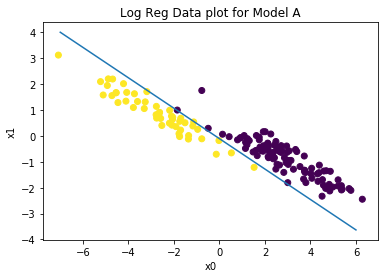

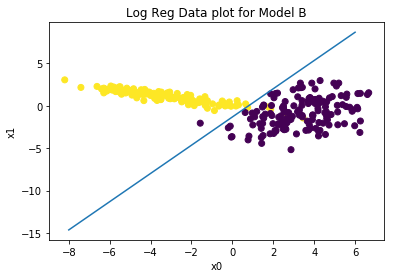

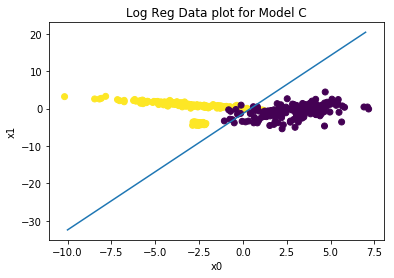

In [964]:
for name in modelNames:
    plotLogRegForModel(name)

### 3) Linear Regression

f is of the form $ f(x) = w^Tx + b . \ $ <br>
We can augment X with a row of 1 to remove b of the Equation. <br>
f thus become $ f(x) = \tilde{w}^T\tilde{x} $ <br>
with $\tilde{x} = (x, 1) $ and $\tilde{w} = (w, b) $

We need to solve the normal equation which is : $$ \tilde{X}^T\tilde{X}\tilde{w}-\tilde{X}^Ty=0 $$

Also we want to plot $ p(y = 1|x) = 0.5 $ <br>
According to our model, $$ p(y|x) = \mathcal{N}((w^Tx + b), \sigma^2) $$ <br>
thus if we want to plot $$ p(y = 1|x) = 0.5 $$ 
we need to solve <br> $$ p(y = 1|x) = p(y = 1|x) = \frac{\mathrm{1} }{ \sqrt{2\pi \sigma^2}}e^{-\frac{(1 - (w^Tx + b))^2}{2\sigma^2}} = 0.5 $$ <br>
This leads to: 
$$x_1 = \frac{1}{w_1}[-w_0x_0 - b + 1 + \sqrt{\sigma^2\ln(\frac{2}{\pi\sigma^2})}\ ]$$

$$or$$

$$x_1 = \frac{1}{w_1}[-w_0x_0 - b + 1 - \sqrt{\sigma^2\ln(\frac{2}{\pi\sigma^2})}\ ]$$

with the condition $$ \sigma^2 \leqslant \frac{2}{\pi} $$

Note that we can estimate $ \sigma $ with the data. Indeed $$ \tilde{\sigma} = \frac{1}{n} || Y - \tilde{w}^T\tilde{X} ||^2 $$

In [965]:
def getLinRegParametersForModel(modelName):
    Y = np.copy(data[modelName +'_train'][:, 2:3])
    X = np.copy(data[modelName + '_train'][:, 0:3])
    # we replace the third row by the augmented row
    X[:, 2] = 1
    
    rank = np.linalg.matrix_rank(X)
    if rank != 3:
        print("XtX isn't invertible")
    X_t = np.transpose(X)
    w = np.dot(np.linalg.inv(np.dot(X_t, X)), np.dot(X_t, Y))
    
    est = np.dot(np.transpose(w), X_t)[0]
    gap = Y[:, 0] - est
    sigma = np.sqrt((np.sum((gap*gap))/len(Y)))
    
    return w[0][0], w[1][0], w[2][0], sigma
    

In [966]:
def printLinRegParametersForModel(modelName):
    omega0, omega1, b, sigma = getLinRegParametersForModel(modelName)
    print('For linear regression of model {0} learnt parameters are :\n\tw = [{1:.3f},{2:.3f}]\n\tb = {3:.3f}\n\tsigma {4:.3f}'.format(modelName,omega0,omega1,b,sigma))

In [938]:
for modelName in modelNames:
    printLinRegParametersForModel(modelName)

For linear regression of model A learnt parameters are :
	w = [-0.264,-0.373]
	b = 0.492
	sigma 0.200
For linear regression of model B learnt parameters are :
	w = [-0.104,0.052]
	b = 0.500
	sigma 0.233
For linear regression of model C learnt parameters are :
	w = [-0.128,-0.017]
	b = 0.508
	sigma 0.249


In [939]:
def LinReg_proba_lim_0(x0,w0,w1,b, sigma):
    sigmaSquare = sigma*sigma
    return 1/w1 * (1 - w0 * x0 - b - np.sqrt(sigmaSquare*np.log(2 / (np.pi*sigmaSquare))))

def LinReg_proba_lim_1(x0,w0,w1,b, sigma):
    sigmaSquare = sigma*sigma
    return 1/w1 * (1- w0 * x0 - b + np.sqrt(sigmaSquare*np.log(2 / (np.pi*sigmaSquare))))

def plotLinRegForModel(modelName): 
    fig, ax = plt.subplots()
    
    dataForModel = data[modelName+ '_train']  
    x_abs = dataForModel[:, 0]
    x_ord = dataForModel[:, 1]
    y = dataForModel[:, 2]
    ax.scatter(x_abs, x_ord, c = y)

  
    x0min = np.min(dataForModel[:, 0])
    lowerBound = int(x0min)
    x0max = np.max(dataForModel[:, 0])
    upperBound = int(x0max) + 1
    
    omega0, omega1, b, sigma = getLinRegParametersForModel(modelName)
    plt.plot(range(lowerBound, upperBound), [LinReg_proba_lim_0(i,omega0, omega1, b, sigma) for i in range(lowerBound, upperBound)])
    plt.plot(range(lowerBound, upperBound), [LinReg_proba_lim_1(i,omega0, omega1, b, sigma) for i in range(lowerBound, upperBound)],color = 'red')
    
    title = "Lin Reg Data plot for Model "+modelName
    plt.title(title)
    plt.xlabel('x0')
    plt.ylabel('x1')

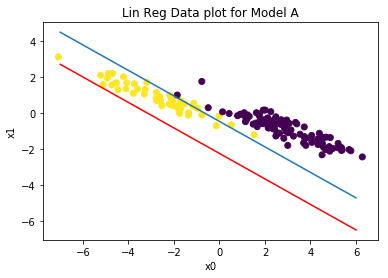

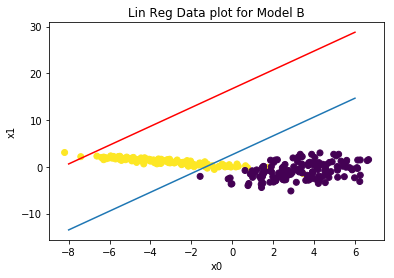

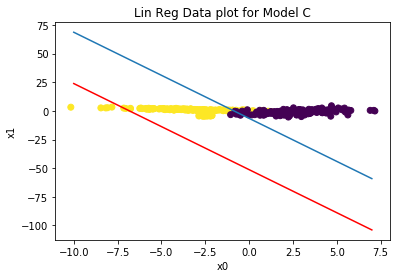

In [940]:
for modelName in modelNames:
    plotLinRegForModel(modelName)
   

In [935]:
def computeCellLayoutForLinReg(modelName):
    printLinRegParametersForModel(modelName)
    plotLinRegForModel(modelName)
    

For linear regression of model A learnt parameters are :
	w = [-0.264,-0.373]
	b = 0.492
	sigma 0.200


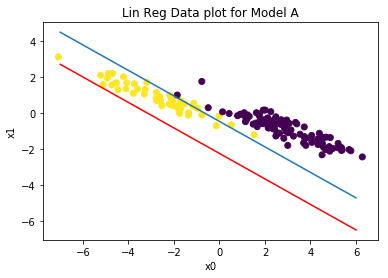

In [941]:
computeCellLayoutForLinReg('A')

### 4) Errors

#### a)

In [987]:
def computeLDAErrorsForModel(modelName, dataSource):
    pi, mu0, mu1, sigma = getLDAParametersForModel(modelName)
    a, b = computeABparam(pi, mu0, mu1, sigma)
    
    X = np.copy(data[modelName + '_' + dataSource][:, 0:2])
    Y = np.copy(data[modelName + '_' + dataSource][:, 2:3])
    
    p = np.dot(X, a) + b
    
    Y_pred = (p > 0).astype(int)
    
    return np.mean(Y.T != Y_pred)

def printLDAErrorForModel(modelName):
    d_types = ['train', 'test']
    for t in d_types:
        err = computeLDAErrorsForModel(modelName, t) * 100
        print('For {0} data of model {1} the error rate is {2:.2f} %'.format(t,modelName,err))

In [988]:
for name in modelNames:
    printLDAErrorForModel(name)   

For train data of model A the error rate is 1.33 %
For test data of model A the error rate is 2.13 %
For train data of model B the error rate is 3.00 %
For test data of model B the error rate is 4.15 %
For train data of model C the error rate is 5.25 %
For test data of model C the error rate is 4.33 %


In [891]:
def computeLogRegErrorsForModel(modelName, dataSource):
    w0, w1, b = getLogRegParametersForModel(modelName)
    
    def logFunc(x0, x1):
        value = w0 * x0 + w1 * x1 + b
        return sigmoid(value)
    
    X = np.copy(data[modelName + '_' + dataSource][:, 0:2])
    Y = np.copy(data[modelName + '_' + dataSource][:, 2:3])
    
    numMissclassified = 0 
    for i in range(len(X)):
        val = logFunc(X[i][0], X[i][1])
        valPredict = 0
        if val >= 0.5:
            valPredict = 1
        if valPredict != Y[i]:
            numMissclassified +=1
    
    return numMissclassified/len(X)
        

In [892]:
def printLogRegParametersForModel(modelName):
    d_types = ['train', 'test']
    for t in d_types:
        err = computeLogRegErrorsForModel(modelName, t) * 100
        print('For {0} data of model {1} the error rate of log reg is {2:.2f} %'.format(t,modelName,err))

In [893]:
for name in modelNames:
    printLogRegParametersForModel(name)

For train data of model A the error rate of log reg is 0.00 %
For test data of model A the error rate of log reg is 3.53 %
For train data of model B the error rate of log reg is 2.00 %
For test data of model B the error rate of log reg is 4.30 %
For train data of model C the error rate of log reg is 4.00 %
For test data of model C the error rate of log reg is 2.27 %


In [27]:
def computeLinRegErrorsForModel(modelName, dataSource):
    w0, w1, b, sigma = getLinRegParametersForModel(name)
    sigmaSquare = sigma*sigma
    
    def logFunc1(x0, x1):
        intermediateValue = (
            1 - w0 * x0 - w1 * x1 - b)**2 / (2 * sigmaSquare)
        value = np.exp(-intermediateValue)/np.sqrt(2*np.pi*sigmaSquare)
        return value
    def logFunc0(x0, x1):
        intermediateValue = (0 - w0 * x0 - w1 * x1 - b)**2 / (2 * sigmaSquare)
        value = np.exp(-intermediateValue)/np.sqrt(2*np.pi*sigmaSquare)
        return value
    
    X = np.copy(data[modelName + '_' + dataSource][:, 0:2])
    Y = np.copy(data[modelName + '_' + dataSource][:, 2:3])
    
    numMissclassified = 0 
    for i in range(len(X)):
        val0 = logFunc0(X[i][0], X[i][1])
        val1 = logFunc1(X[i][0], X[i][1])
        
        valPredict = 0
        if val1 > val0:
            valPredict = 1
        if valPredict != Y[i]:
            numMissclassified +=1
    
    return numMissclassified/len(X)

In [28]:
def printLinRegParametersForModel(modelName):
    d_types = ['train', 'test']
    for t in d_types:
        err = computeLinRegErrorsForModel(modelName, t) * 100
        print('For {0} data of model {1} the error rate of lin reg is {2:.3f} %'.format(t,modelName,err))

In [29]:
for name in modelNames:
    printLinRegParametersForModel(name)

For train data of model A the error rate of lin reg is 1.333 %
For test data of model A the error rate of lin reg is 2.067 %
For train data of model B the error rate of lin reg is 3.000 %
For test data of model B the error rate of lin reg is 4.150 %
For train data of model C the error rate of lin reg is 5.500 %
For test data of model C the error rate of lin reg is 4.233 %


### 5) QDA

$$ log\big(p(y|x)\big) = 
log(\pi)\sum_i y_i + log(1-\pi)\sum_i(1- y_i) 
-\frac{\sum_i y_i}{2}log\big(det(\Sigma_1)\big) 
-\frac{\sum_i 1-y_i}{2}log\big(det(\Sigma_0)\big)
-\frac{1}{2}\sum_i y_i (x_i - \mu_0)^T \Sigma_1^{-1}(x_i-\mu_0)
-\frac{1}{2}\sum_i (1-y_i)(x_i - \mu_0)^T \Sigma_0^{-1}(x_i-\mu_0)
+ Cste  $$

* Estimation de $\mu_0$ (même calcul que le LDA):
$$
\hat{\mu}_0 = \frac{\sum_i x_i^T(1-y_i)}{\sum_i (1-y_i)}
$$


* Estimation de $\mu_1$ (même calcul que le LDA):
$$
\hat{\mu}_1  = \frac{\sum_i y_i x_i}{\sum_i y_i}
$$

* Estimation de $\pi$(même calcul que le LDA):
$$
\hat{\pi} = \frac{\sum_i y_i}{n}
$$

* Estimation de $\Sigma_0$:
On pose $\Lambda_0 = \Sigma_0^{-1}$, et par un calcul similaire à celui du LDA on a:
$$
\nabla_{\Lambda_0}\Big(log\big(p(y|x)\big)\Big) = 0
$$
$$
\Leftrightarrow \frac{\sum_i (1-y_i)}{2} \Sigma_0
- \sum_i \frac{(1-y_i)}{2} (x_i - \mu_0)^T(x_i - \mu_0) = 0
$$
$$
\Leftrightarrow \hat\Sigma_0 =
\frac{\sum_i (1-y_i) (x_i - \mu_0)^T(x_i - \mu_0)}{\sum_i (1-y_i)}
$$

* Estimation de $\Sigma_1$ (idem):
$$
\hat\Sigma_1 =
\frac{\sum_i y_i (x_i - \mu_1)^T(x_i - \mu_1)}{\sum_i y_i}
$$

* Calul de $p(y = 1|x)$:
$$
p(y = 1|x) = \frac{1}{1+\frac{p(x|y=0)p(y=0)}{p(x|y=1)p(y=1)}}
$$
$$
p(y = 1|x) = \frac{1}{1+\frac{\pi}{1-\pi}exp\big( -\frac{1}{2}(x-\mu_0)^T\Sigma_0^{-1}(x-\mu_0) + \frac{1}{2}(x-\mu_1)^T\Sigma_1^{-1}(x-\mu_1) \big)}
$$
Donc
$$
p(y = 1|x) = 0.5
$$
$$
\Leftrightarrow \frac{1}{2}(x-\mu_1)^T\Sigma_1^{-1}(x-\mu_1) - \frac{1}{2}(x-\mu_0)^T\Sigma_0^{-1}(x-\mu_0) + log\big(\frac{\pi}{1-\pi}\big) = 0
$$
$$
\Leftrightarrow x^T(\Sigma_1^{-1}-\Sigma_0^{-1})x - 2 x^T(\Sigma_1^{-1}\mu_1 - \Sigma_0^{-1}\mu_0) + \mu_1\Sigma_1^{-1}\mu_1 - \mu_0\Sigma_0^{-1}\mu_0 + 2log(\frac{\pi}{1-\pi}) = 0
$$
qui est bien une forme quadratique si $\Sigma_0 \neq \Sigma_1$, ce qui est l'hypothèse du QDA. Autrement, on retombe sur le cas du LDA question 1).

In [952]:
def getQDAParametersForModel(modelName):
    dataForModel = data[modelName+ '_train']
    
    # x0 est l'ensemble des xi pour lesquels yi = 0
    x0 = dataForModel[:, 0:2][dataForModel[:, 2]==0]
    mu0 = np.mean(x0, axis=0)
    
    # x1 est l'ensemble des xi pour lesquels yi = 1
    x1 = dataForModel[:, 0:2][dataForModel[:, 2]==1]
    mu1 = np.mean(x1, axis=0)
    
    pi = np.mean(dataForModel[:, 2])

    sigma0 = np.dot((x0 - mu0).T, x0 - mu0)/len(x0)
    sigma1 = np.dot((x1 - mu1).T, x1 - mu1)/len(x1)
    return pi, mu0, mu1, sigma0, sigma1

def plotQDAForModel(modelName): 
    pi, mu0, mu1, sigma0, sigma1 = getQDAParametersForModel(modelName)
    sigmainv0 = inv(sigma0)
    sigmainv1 = inv(sigma1)
    
    fig, ax = plt.subplots()
    dataForModel = data[modelName+ '_train']

    x0min = np.min(dataForModel[:, 0])
    x0max = np.max(dataForModel[:, 0])
    x1min = np.min(dataForModel[:, 1])
    x1max = np.max(dataForModel[:, 1])
    
    k = 100
    
    x0list = np.linspace(x0min, x0max, k)
    x1list = np.linspace(x1min, x1max, k)
    X0, X1 = np.meshgrid(x0list, x1list)
    
    X = np.array([X0, X1]).reshape(len(mu0), -1)
    
    A = sigmainv0 - sigmainv1
    quadratic_term = np.diag(np.dot(X.T, np.dot(A, X)))
    
    B = np.dot(sigmainv0, mu0) - np.dot(sigmainv1, mu1)
    linear_term = np.dot(X.T, B)
    
    C = np.dot(mu0.T, np.dot(sigmainv0, mu0)) - np.dot(mu1.T, np.dot(sigmainv1, mu1)) + 2*np.log(pi/(1-pi))
    intercept_term = np.repeat(C, X.shape[1])
    
    F =  quadratic_term + linear_term + intercept_term
    
    Z = F.reshape(X0.shape)
    CS = ax.contour(X0, X1, Z)
    ax.clabel(CS, inline=1, fontsize=10)

    x_abs = dataForModel[:, 0]
    x_ord = dataForModel[:, 1]
    y = dataForModel[:, 2]
    ax.scatter(x_abs, x_ord, c = y)
    
    title = "QDA Data plot for Model "+modelName
    plt.title(title)
    plt.xlabel('x0')
    plt.ylabel('x1')
    
def computeQDAErrorsForModel(modelName, dataSource):
    pi, mu0, mu1, sigma0, sigma1 = getQDAParametersForModel(modelName)
    sigmainv0 = inv(sigma0)
    sigmainv1 = inv(sigma1)
    
    X = np.copy(data[modelName + '_' + dataSource][:, 0:2])
    Y = np.copy(data[modelName + '_' + dataSource][:, 2:3])
    

    a0 = np.diag(np.dot(np.dot(X-mu0, sigmainv0), (X-mu0).T))/2
    a1 = np.diag(np.dot(np.dot(X-mu1, sigmainv1), (X-mu1).T))/2
    
    p = 1/(1 + pi/(1-pi)*np.exp(a1-a0))
    
    Y_pred = (p > .5).astype(int)
    
    
    return np.mean(Y_pred != Y.T)


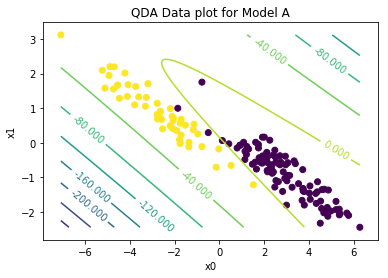

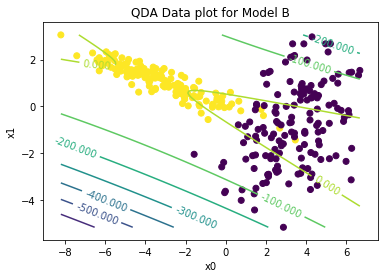

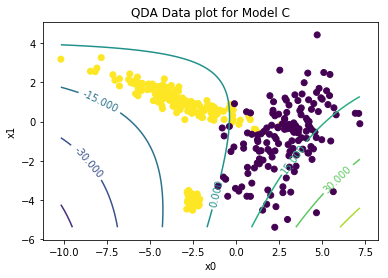

In [946]:
for name in modelNames:
    plotQDAForModel(name)

In [950]:
def printQDAParametersForModel(modelName):
    pi, mu0, mu1, sigma0, sigma1 = getQDAParametersForModel(modelName)
    print("QDA parameters for model {0}".format(modelName), pi, mu0, mu1, sigma0, sigma1)
            
for modelName in modelNames:
    printQDAParametersForModel(modelName)
        

QDA parameters for model A 0.3333333333333333 [ 2.89970947 -0.893874  ] [-2.69232004  0.866042  ] [[ 2.31065259 -1.04748461]
 [-1.04748461  0.57578403]] [[ 2.70442172 -1.3008515 ]
 [-1.3008515   0.68969588]]
QDA parameters for model B 0.5 [ 3.34068896 -0.83546333] [-3.21670734  1.08306733] [[2.53885859 1.0642112 ]
 [1.0642112  2.96007891]] [[ 4.15361075 -1.33454097]
 [-1.33454097  0.51607059]]
QDA parameters for model C 0.625 [ 2.79304824 -0.83838667] [-2.94232885 -0.9578284 ] [[2.89913927 1.24581553]
 [1.24581553 2.92475448]] [[ 2.86914403 -1.76197061]
 [-1.76197061  6.56438626]]


In [968]:
def printQDAErrorsForModels(modelName):
    d_types = ['train', 'test']
    for t in d_types:
        err = computeQDAErrorsForModel(modelName, t) * 100
        print('For {0} data of model {1} the error rate for QDA is {2:.2f} %'.format(t,modelName,err))
        
for name in modelNames:
    printQDAErrorsForModels(name)

For train data of model A the error rate for QDA is 1.33 %
For test data of model A the error rate for QDA is 2.60 %
For train data of model B the error rate for QDA is 2.33 %
For test data of model B the error rate for QDA is 2.35 %
For train data of model C the error rate for QDA is 4.50 %
For test data of model C the error rate for QDA is 3.57 %
